# Fine Tuning Tutorial
## TensorFlow 2 Detection Model Zoo

Reference: https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from PIL import Image, ImageColor, ImageDraw, ImageFont
from six import BytesIO
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
from object_detection.utils import config_util
from object_detection.builders import model_builder
from object_detection.utils import visualization_utils as viz_utils
from sklearn.model_selection import train_test_split

import concurrent.futures
import requests
import tarfile
import random

from datetime import datetime
import time

%matplotlib inline

In [3]:
# Function to load an image and convert it to numpy array with uint8
def load_image_into_numpy_array(image_path):
    return np.array(Image.open(image_path))

# Function to resize image and adjust bounding box coordinates to ratio
def resize_image_and_boxes(image, boxes, target_size):
    orig_height, orig_width = image.shape[:2]
    target_height, target_width = target_size

    # Resize image
    image = tf.image.resize(image, target_size).numpy()

    if boxes.size > 0:  # Check if boxes are not empty
        # Adjust bounding boxes to ratio
        boxes[:, [0, 2]] /= orig_height
        boxes[:, [1, 3]] /= orig_width

    return image, boxes

# Function to process a single image and annotation
def process_image_annotation(image_file, image_dir, annotation_dir, target_size=(640, 640)):
    image_path = os.path.join(image_dir, image_file)
    annotation_path = os.path.join(annotation_dir, image_file.replace(".jpg", ".xml"))

    if not os.path.exists(annotation_path):
        return None

    # Load image
    image_np = load_image_into_numpy_array(image_path)

    # Parse annotation
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    boxes = []
    classes = []
    for member in root.findall('object'):
        class_name = member[0].text
        if class_name == 'D00':
            class_id = 1
        elif class_name == 'D10':
            class_id = 2
        elif class_name == 'D20':
            class_id = 3
        elif class_name == 'D40':
            class_id = 4
        else:
            continue

        classes.append(class_id)
        bndbox = member.find('bndbox')
        ymin = int(bndbox.find('ymin').text)
        xmin = int(bndbox.find('xmin').text)
        ymax = int(bndbox.find('ymax').text)
        xmax = int(bndbox.find('xmax').text)
        boxes.append([ymin, xmin, ymax, xmax])

    boxes = np.array(boxes, dtype=np.float32)
    classes = np.array(classes, dtype=np.int32)

    # Resize image and convert boxes to ratio
    image_np, boxes = resize_image_and_boxes(image_np, boxes, target_size)

    # Convert image to uint8
    image_np = image_np.astype(np.uint8)

    return image_np, boxes, classes

# Function to load all data
def load_data(image_dir, annotation_dir, target_size=(640, 640), num_images=None, max_workers=4):
    images_np = []
    gt_boxes = []
    gt_classes = []

    image_files = sorted(os.listdir(image_dir))
    if num_images:
        image_files = image_files[:num_images]

    def process_file(image_file):
        return process_image_annotation(image_file, image_dir, annotation_dir, target_size)

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(process_file, image_files))

    for result in results:
        if result is not None:
            image_np, boxes, classes = result
            if boxes.size > 0:  # Skip images without bounding boxes
                images_np.append(image_np)
                gt_boxes.append(boxes)
                gt_classes.append(classes)

    return images_np, gt_boxes, gt_classes

In [4]:
# Load all data
image_dir = '../data-collection/RDD2022_Japan/filtered/images'
annotation_dir = '../data-collection/RDD2022_Japan/filtered/annotations'
images_np, gt_boxes, gt_classes = load_data(image_dir, annotation_dir)

In [5]:
print(f"Loaded {len(images_np)} images.")
for i in range(1):
    print(f"Image {i+1}:")
    print(f"Shape: {images_np[i]}")
    print(f"Boxes: {gt_boxes[i]}")
    print(f"Classes: {gt_classes[i]}")

Loaded 4133 images.
Image 1:
Shape: [[[ 60 120 190]
  [ 53 113 183]
  [ 47 107 177]
  ...
  [ 86 143 196]
  [ 86 143 196]
  [ 86 143 196]]

 [[ 79 139 207]
  [ 74 135 202]
  [ 68 129 196]
  ...
  [ 90 147 200]
  [ 91 148 201]
  [ 92 149 202]]

 [[ 82 142 208]
  [ 84 143 209]
  [ 84 143 209]
  ...
  [ 92 149 202]
  [ 93 150 203]
  [ 94 151 204]]

 ...

 [[ 85  90  84]
  [ 81  86  80]
  [ 86  91  85]
  ...
  [ 83  85  80]
  [ 80  82  77]
  [ 78  80  75]]

 [[ 66  71  65]
  [ 63  68  62]
  [ 70  75  69]
  ...
  [ 79  81  76]
  [ 80  82  77]
  [ 86  88  83]]

 [[ 83  88  82]
  [ 69  74  68]
  [ 80  85  79]
  ...
  [ 73  75  70]
  [ 74  76  71]
  [ 90  92  87]]]
Boxes: [[0.7916667  0.6766667  0.99333334 1.        ]
 [0.62166667 0.6816667  0.7866667  0.99666667]
 [0.86333334 0.6566667  0.92333335 0.92833334]
 [0.75666666 0.85       0.9033333  0.93333334]]
Classes: [3 4 2 1]


In [6]:
# Split data into train, validation, and test sets
train_images, test_images, train_boxes, test_boxes, train_classes, test_classes = train_test_split(
    images_np, gt_boxes, gt_classes, test_size=0.2, random_state=42)

train_images, val_images, train_boxes, val_boxes, train_classes, val_classes = train_test_split(
    train_images, train_boxes, train_classes, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")

Training set size: 2644
Validation set size: 662
Test set size: 827


In [23]:
# Function to visualize detections
def plot_detections(image_np, boxes, classes, scores, category_index, figsize=(12, 16), image_name=None):
    """Wrapper function to visualize detections."""
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.2)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

In [8]:
# Prepare data for training
d_00_class_id = 1
d_10_class_id = 2
d_20_class_id = 3
d_40_class_id = 4
num_classes = 4
category_index = {d_00_class_id: {'id': d_00_class_id, 'name': 'D00'},
                  d_10_class_id: {'id': d_10_class_id, 'name': 'D10'},
                  d_20_class_id: {'id': d_20_class_id, 'name': 'D20'},
                  d_40_class_id: {'id': d_40_class_id, 'name': 'D40'}}

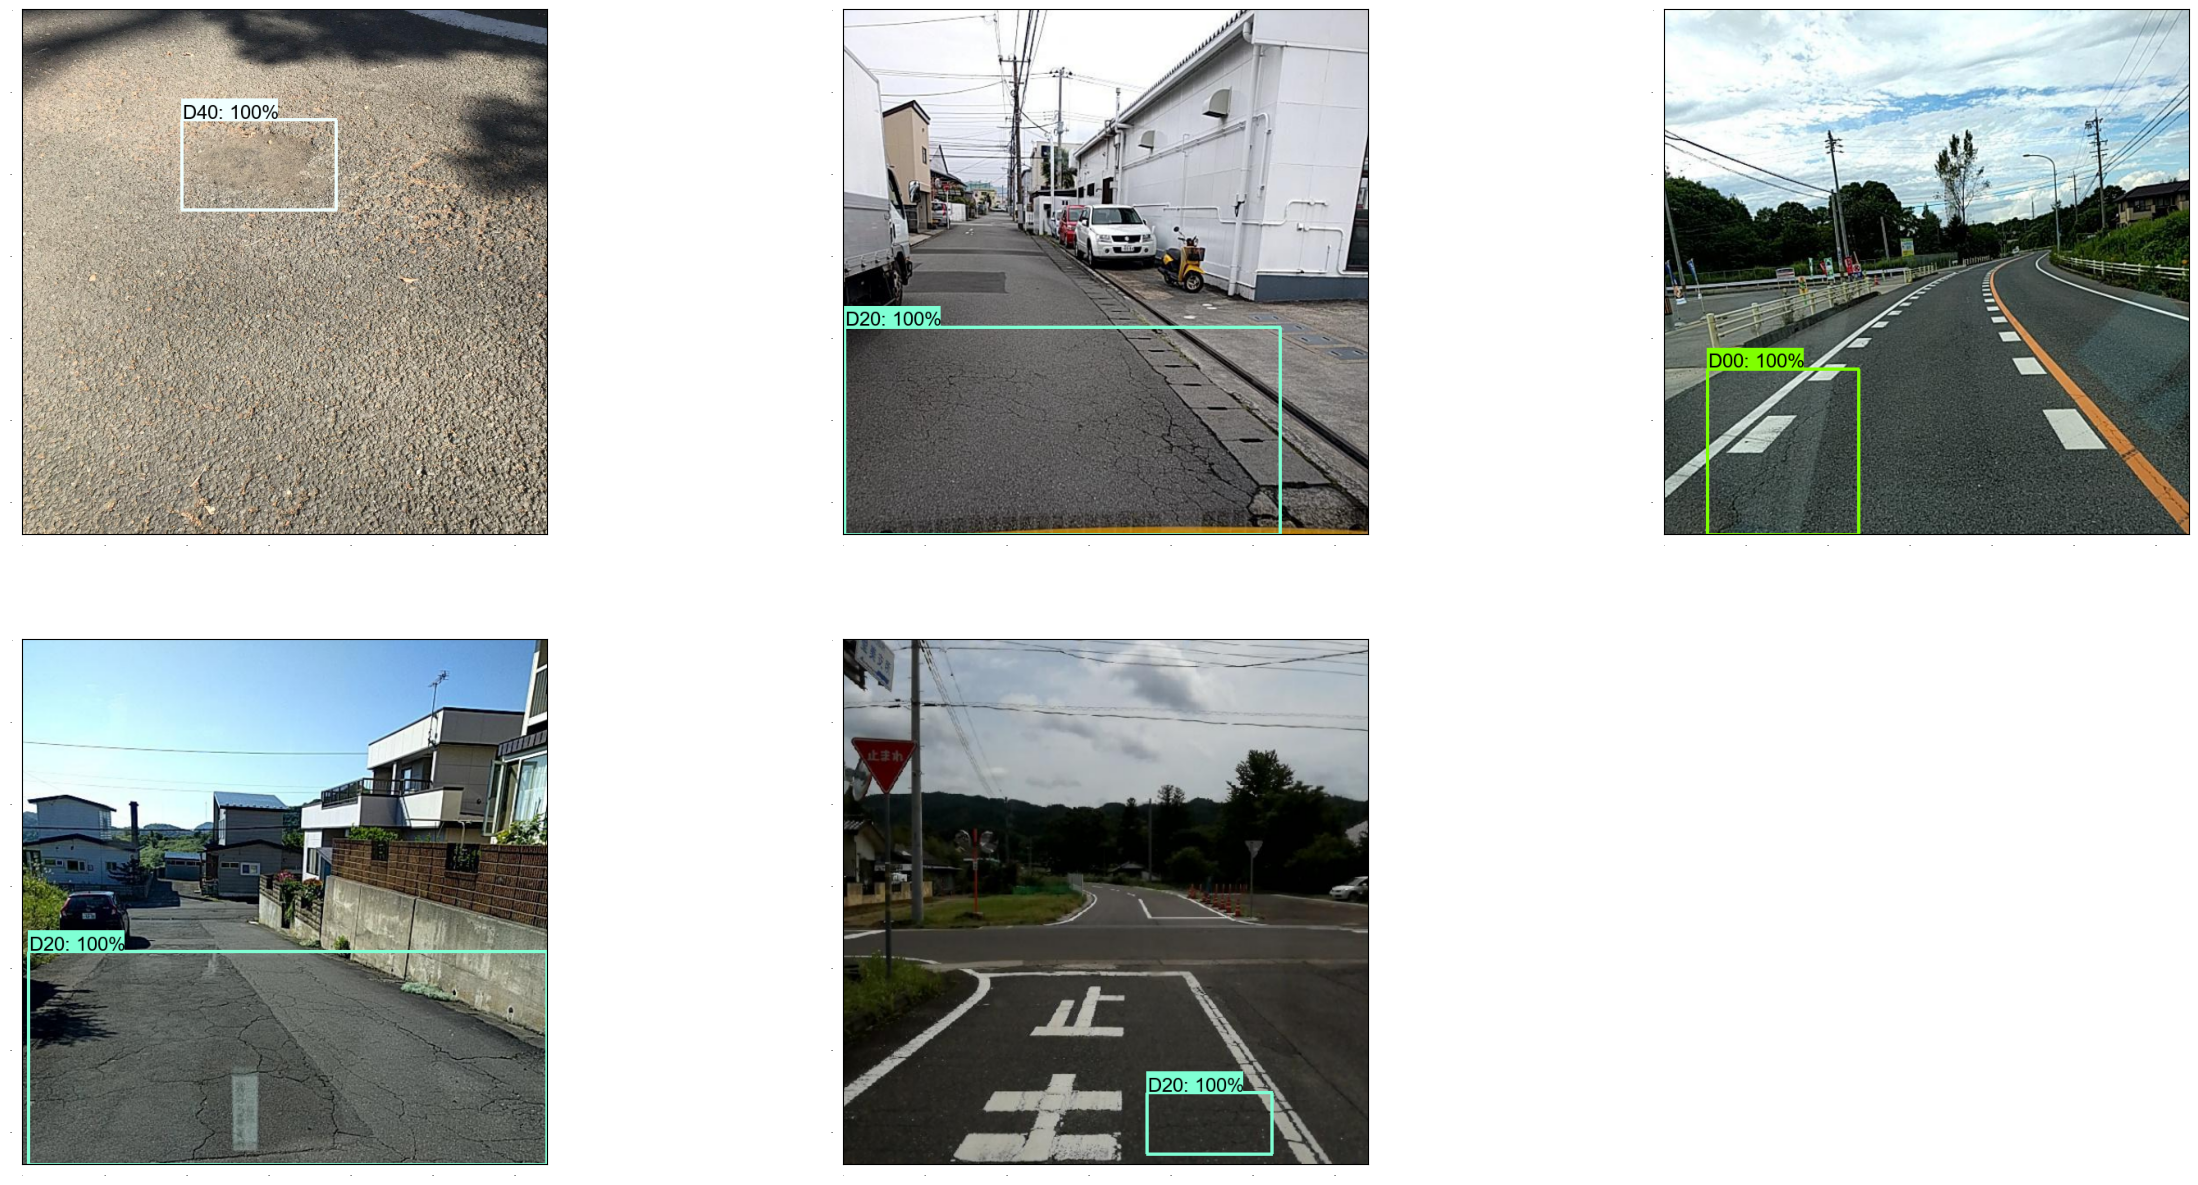

In [9]:
# Set visualization parameters
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

num_boxes_max = 20

# Visualize the rubber duckies as a sanity check
dummy_scores = np.array([1.0] * num_boxes_max, dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
    plt.subplot(2, 3, idx+1)
    plot_detections(
        train_images[idx],
        train_boxes[idx],
        train_classes[idx],
        dummy_scores, category_index)
plt.show()

In [10]:
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np, class_np) in zip(train_images, train_boxes, train_classes):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(class_np - label_id_offset, dtype=tf.int32)
    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


In [11]:
# URL for the pretrained model
model_url = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz"
output_dir = "../models/my_custom_model"

In [12]:
# Function to download and extract model into a specific directory
def download_and_extract_model(url, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    response = requests.get(url, stream=True)
    tar_file_path = os.path.join(output_dir, "model.tar.gz")
    with open(tar_file_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    with tarfile.open(tar_file_path, "r:gz") as tar:
        tar.extractall(path=output_dir)
    os.remove(tar_file_path)

# Download and extract the model checkpoint into a custom directory
download_and_extract_model(model_url, output_dir)

In [13]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 4
pipeline_config = '../models/research/object_detection/configs/tf2/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = os.path.join(output_dir, 'ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8', 'checkpoint', 'ckpt-0')

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head)
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [14]:
# Print the number of parameters for each layer
total_params = 0

trainable_variables = detection_model.trainable_variables

for var in trainable_variables:
    var_params = tf.size(var).numpy()  # Number of parameters in each variable
    total_params += var_params
    print(f"{var.name}: {var_params} parameters")

print(f"Total number of trainable variables: {len(trainable_variables)}")
print(f"Total number of trainable parameters: {total_params}")

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0: 55296 parameters
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0: 24 parameters
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0: 69120 parameters
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0: 30 parameters
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0: 589824 parameters
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0: 256 parameters
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/beta:0: 256 parameters
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/kernel:0: 589824 parameters
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/BatchNorm/feature_0/gamma:0: 256 parameters
WeightSharedConvolutionalBoxPredictor/Box

In [15]:
tf.keras.backend.set_learning_phase(True)

batch_size = 4
learning_rate = 0.01
num_batches = 100

trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

total_params = sum([tf.size(var).numpy() for var in to_fine_tune])
print(f"Total number of trainable parameters for fine-tuning: {total_params}")



def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    @tf.function
    def train_step_fn(image_tensors, groundtruth_boxes_list, groundtruth_classes_list):
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat([detection_model.preprocess(image_tensor)[0] for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss
    return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune)

Total number of trainable parameters for fine-tuning: 124470


c:\Users\flag8\.venv\tensorflow-gpu\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [17]:
print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
    all_keys = list(range(len(train_images)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]

    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches) + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=2.123322


batch 10 of 100, loss=1.5321503
batch 20 of 100, loss=1.7456334
batch 30 of 100, loss=1.6492803
batch 40 of 100, loss=1.7022641
batch 50 of 100, loss=1.5022645
batch 60 of 100, loss=1.280987
batch 70 of 100, loss=1.6963086
batch 80 of 100, loss=1.5461034
batch 90 of 100, loss=1.3962584
Done fine-tuning!


In [18]:
test_images_np = []
for i in range(0, 50):
    test_images_np.append(np.expand_dims(test_images[i], axis=0))

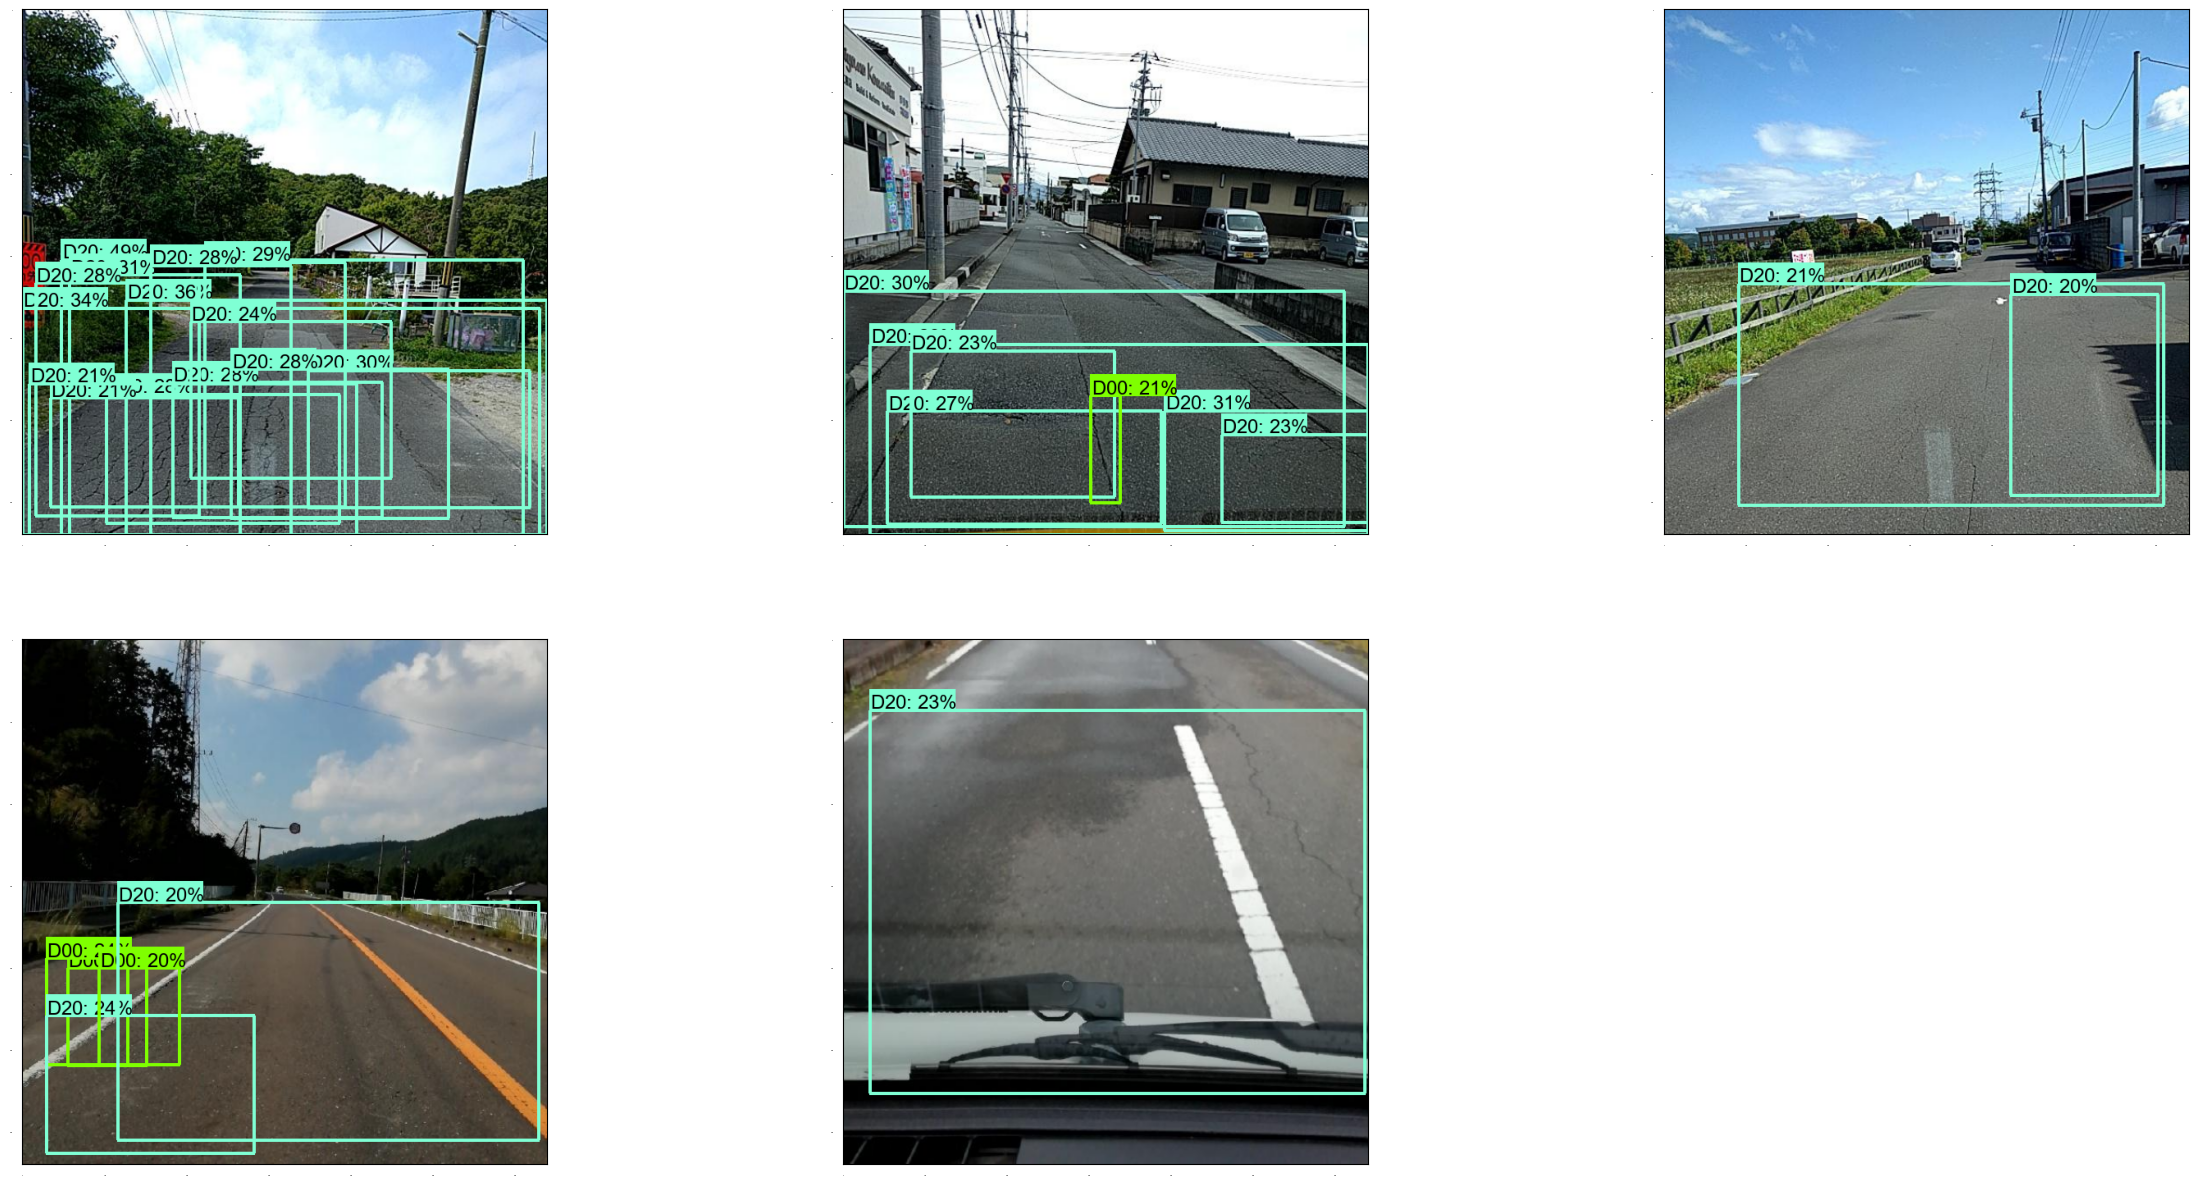

In [24]:
@tf.function
def detect(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

label_id_offset = 1
plt.figure(figsize=(30, 15))
for idx in range(5):  # Visualize 5 test images
    input_tensor = tf.convert_to_tensor(test_images_np[idx], dtype=tf.float32)
    detections = detect(input_tensor)

    # Extract all detected boxes, classes, and scores
    boxes = detections['detection_boxes'][0].numpy()
    classes = detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset
    scores = detections['detection_scores'][0].numpy()

    plt.subplot(2, 3, idx+1)
    plot_detections(
        test_images_np[idx][0],
        boxes,
        classes,
        scores,
        category_index)
plt.show()

In [25]:
def calculate_iou(gt_box, pred_box):
    xA = max(gt_box[1], pred_box[1])
    yA = max(gt_box[0], pred_box[0])
    xB = min(gt_box[3], pred_box[3])
    yB = min(gt_box[2], pred_box[2])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (gt_box[3] - gt_box[1]) * (gt_box[2] - gt_box[0])
    boxBArea = (pred_box[3] - pred_box[1]) * (pred_box[2] - pred_box[0])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def calculate_map(groundtruth_boxes, detection_boxes, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for gt_boxes, pred_boxes in zip(groundtruth_boxes, detection_boxes):
        matched = False
        for gt_box in gt_boxes:
            for pred_box in pred_boxes:
                iou = calculate_iou(gt_box, pred_box)
                if iou > iou_threshold:
                    true_positives += 1
                    matched = True
                    break
            if matched:
                break
        if not matched:
            false_negatives += 1
        false_positives += len(pred_boxes) - true_positives

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    ap = precision * recall  # For simplification, using precision * recall as AP

    return ap


In [26]:
# Perform inference and gather results
detections = []

for test_image_np in test_images_np:
    input_tensor = tf.convert_to_tensor(test_image_np, dtype=tf.float32)
    detections.append(detect(input_tensor))

# Extract boxes, classes, and scores from detections
detection_boxes = [d['detection_boxes'][0].numpy() for d in detections]
detection_classes = [d['detection_classes'][0].numpy().astype(np.uint32) for d in detections]
detection_scores = [d['detection_scores'][0].numpy() for d in detections]

In [27]:
groundtruth_boxes = [gt_box for gt_box in test_boxes]  # Ground truth boxes from your test dataset

# Calculate IoU for each image
ious = []
for gt_boxes, pred_boxes in zip(groundtruth_boxes, detection_boxes):
    for gt_box in gt_boxes:
        for pred_box in pred_boxes:
            ious.append(calculate_iou(gt_box, pred_box))

# Calculate mean IoU
mean_iou = np.mean(ious)
print(f'Mean IoU: {mean_iou}')

# Calculate mAP
map_score = calculate_map(groundtruth_boxes, detection_boxes)
print(f'mAP: {map_score}')

Mean IoU: 0.06377113791712868
mAP: 0.003939110070257611
